In [ ]:

!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install transformers torch scikit-learn pandas numpy matplotlib seaborn tqdm nltk textblob symspellpy


Looking in indexes: https://download.pytorch.org/whl/cu118
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.6/159.6 kB 16.4 MB/s eta 0:00:00


In [ ]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

True
Tesla T4


## Step 2: Upload Raw Dataset

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings

In [ ]:

warnings.filterwarnings('ignore')

# Load raw dataset
df_raw = pd.read_csv('/content/drive/MyDrive/dataset/Suicide_Detection (1).csv')

# Display basic info
print("Dataset Shape:", df_raw.shape)
print("\nFirst few rows:")
print(df_raw.head())
print("\nColumn names:")
print(df_raw.columns.tolist())
print("\nData types:")
print(df_raw.dtypes)
print("\nMissing values:")
print(df_raw.isnull().sum())
print("\nClass distribution:")
print(df_raw['class'].value_counts())

Dataset Shape: (232074, 3)

First few rows:
   Unnamed: 0                                               text        class
0           2  Ex Wife Threatening SuicideRecently I left my ...      suicide
1           3  Am I weird I don't get affected by compliments...  non-suicide
2           4  Finally 2020 is almost over... So I can never ...  non-suicide
3           8          i need helpjust help me im crying so hard      suicide
4           9  I’m so lostHello, my name is Adam (16) and I’v...      suicide

Column names:
['Unnamed: 0', 'text', 'class']

Data types:
Unnamed: 0     int64
text          object
class         object
dtype: object

Missing values:
Unnamed: 0    0
text          0
class         0
dtype: int64

Class distribution:
class
suicide        116037
non-suicide    116037
Name: count, dtype: int64


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Class distribution
class_counts = df_raw['class'].value_counts()
print("Class Distribution:")
print(class_counts)
print(f"\nPercentage: ")
print(df_raw['class'].value_counts(normalize=True) * 100)

# Visualize
plt.figure(figsize=(8, 5))
sns.countplot(data=df_raw, x='class')
plt.title('Class Distribution in Raw Data')
plt.ylabel('Count')
plt.show()

Average text length: 131.93
Median text length: 60.00
Min text length: 1
Max text length: 9684
95th percentile: 471.00
75th percentile: 155.00


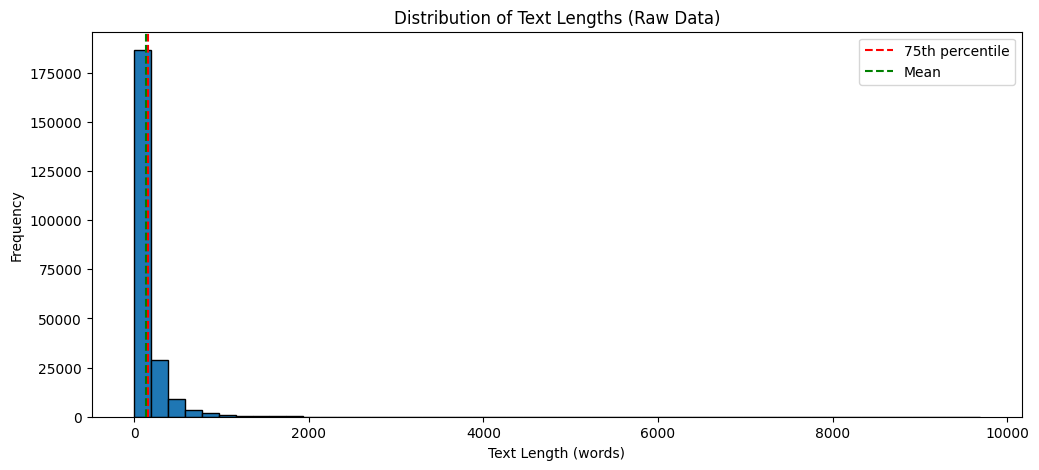

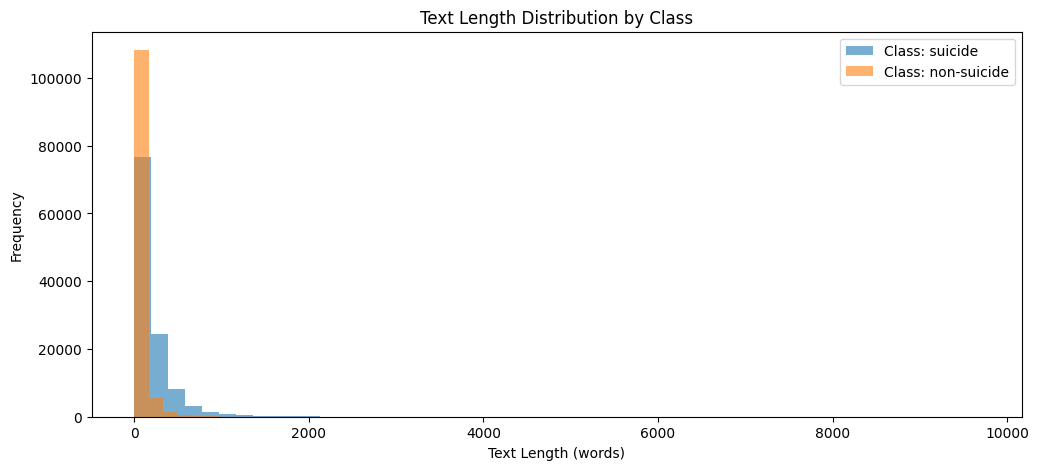

In [ ]:
# Calculate text length statistics
df_raw['text_length'] = df_raw['text'].apply(lambda x: len(str(x).split()))

print(f"Average text length: {df_raw['text_length'].mean():.2f}")
print(f"Median text length: {df_raw['text_length'].median():.2f}")
print(f"Min text length: {df_raw['text_length'].min()}")
print(f"Max text length: {df_raw['text_length'].max()}")
print(f"95th percentile: {df_raw['text_length'].quantile(0.95):.2f}")
print(f"75th percentile: {df_raw['text_length'].quantile(0.75):.2f}")

# Visualize distribution
plt.figure(figsize=(12, 5))
plt.hist(df_raw['text_length'], bins=50, edgecolor='black')
plt.axvline(df_raw['text_length'].quantile(0.75), color='red', linestyle='--', label='75th percentile')
plt.axvline(df_raw['text_length'].mean(), color='green', linestyle='--', label='Mean')
plt.xlabel('Text Length (words)')
plt.ylabel('Frequency')
plt.title('Distribution of Text Lengths (Raw Data)')
plt.legend()
plt.show()

# By class
plt.figure(figsize=(12, 5))
for cls in df_raw['class'].unique():
    subset = df_raw[df_raw['class'] == cls]['text_length']
    plt.hist(subset, bins=50, alpha=0.6, label=f'Class: {cls}')
plt.xlabel('Text Length (words)')
plt.ylabel('Frequency')
plt.title('Text Length Distribution by Class')
plt.legend()
plt.show()

In [ ]:
# Look at sample suicide posts
print("=" * 80)
print("SAMPLE SUICIDAL POSTS:")
print("=" * 80)
for i, text in enumerate(df_raw[df_raw['class'] == 'suicide']['text'].head(3)):
    print(f"\nExample {i+1}:")
    print(text[:200] + "..." if len(text) > 200 else text)

print("\n" + "=" * 80)
print("SAMPLE NON-SUICIDAL POSTS:")
print("=" * 80)
for i, text in enumerate(df_raw[df_raw['class'] == 'non-suicide']['text'].head(3)):
    print(f"\nExample {i+1}:")
    print(text[:200] + "..." if len(text) > 200 else text)

SAMPLE SUICIDAL POSTS:

Example 1:
Ex Wife Threatening SuicideRecently I left my wife for good because she has cheated on me twice and lied to me so much that I have decided to refuse to go back to her. As of a few days ago, she began ...

Example 2:
i need helpjust help me im crying so hard

Example 3:
I’m so lostHello, my name is Adam (16) and I’ve been struggling for years and I’m afraid. Through these past years thoughts of suicide, fear, anxiety I’m so close to my limit . I’ve been quiet for so ...

SAMPLE NON-SUICIDAL POSTS:

Example 1:
Am I weird I don't get affected by compliments if it's coming from someone I know irl but I feel really good when internet strangers do it

Example 2:
Finally 2020 is almost over... So I can never hear "2020 has been a bad year" ever again. I swear to fucking God it's so annoying

Example 3:
Everyone wants to be "edgy" and it's making me self conscious I feel like I don't stand out. I can draw yes and play the guitar but I honestly feel like am st

In [ ]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Download required NLTK data (FIXED - added punkt_tab)
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Initialize
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# IMPORTANT: Retain "no" and "not" as they indicate negative sentiment
stop_words.discard('no')
stop_words.discard('not')

def preprocess_text(text):
    """Complete text preprocessing pipeline"""

    # 1. Convert to lowercase
    text = str(text).lower()

    # 2. Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # 3. Remove email addresses
    text = re.sub(r'\S+@\S+', '', text)

    # 4. Remove special characters and digits (keep basic punctuation)
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # 5. Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    # 6. Tokenize
    tokens = word_tokenize(text)

    # 7. Remove stopwords (except "no" and "not")
    tokens = [token for token in tokens if token not in stop_words or token in ['no', 'not']]

    # 8. Lemmatization (better than stemming - considers context)
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # 9. Join back
    cleaned_text = ' '.join(tokens)

    return cleaned_text

# Test on sample
print("Original text:")
print(df_raw['text'].iloc[0][:150])
print("\nPreprocessed text:")
print(preprocess_text(df_raw['text'].iloc[0])[:150])

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


Original text:
Ex Wife Threatening SuicideRecently I left my wife for good because she has cheated on me twice and lied to me so much that I have decided to refuse t

Preprocessed text:
ex wife threatening suiciderecently left wife good cheated twice lied much decided refuse go back day ago began threatening suicide tirelessly spent p


#4.3 Apply Preprocessing to All Data


In [ ]:


from tqdm.notebook import tqdm
tqdm.pandas()

print("Preprocessing all texts.")

df_preprocessed = df_raw.copy()
df_preprocessed['text'] = df_preprocessed['text'].progress_apply(preprocess_text)

print("✓ Preprocessing complete!")
print("\nPreprocessed data sample:")
print(df_preprocessed[['text', 'class']].head())


#Step 5: Data Cleaning
5.1 Remove Empty and Short Texts


In [ ]:
# Calculate word count after preprocessing
df_preprocessed['word_count'] = df_preprocessed['text'].apply(lambda x: len(str(x).split()))

print(f"Original dataset size: {len(df_preprocessed)}")

# Remove empty texts
df_cleaned = df_preprocessed[df_preprocessed['text'].str.strip() != ''].copy()
print(f"After removing empty texts: {len(df_cleaned)}")

# Remove texts with very few words (< 2)
df_cleaned = df_cleaned[df_cleaned['word_count'] >= 2].copy()
print(f"After removing texts with < 2 words: {len(df_cleaned)}")

print(f"\nWord count statistics:")
print(df_cleaned['word_count'].describe())

Original dataset size: 232074
After removing empty texts: 231982
After removing texts with < 2 words: 231724

Word count statistics:
count    231724.000000
mean         65.177681
std         107.776723
min           2.000000
25%          14.000000
50%          31.000000
75%          77.000000
max        5717.000000
Name: word_count, dtype: float64


tells that word count of sentences on avg is 65

5.2 Remove Anomalies and Outliers

In [ ]:
# Find most frequent words
all_words = ' '.join(df_cleaned['text']).split()
word_freq = Counter(all_words)
most_common = word_freq.most_common(50)

print("Top 30 most frequent words:")
for word, count in most_common[:30]:
    print(f"{word}: {count}")

# Remove rows containing meaningless filler words
anomalous_words = ['filler', 'xxx', 'nan', 'unk']

for word in anomalous_words:
    initial_len = len(df_cleaned)
    df_cleaned = df_cleaned[~df_cleaned['text'].str.contains(word, case=False, na=False)]
    if len(df_cleaned) < initial_len:
        print(f"Removed {initial_len - len(df_cleaned)} rows containing '{word}'")

print(f"After removing anomalous words: {len(df_cleaned)}")

Top 30 most frequent words:
im: 341414
dont: 214180
like: 184249
not: 170678
want: 158934
know: 137428
feel: 136530
life: 127476
get: 120568
no: 110731
ive: 110128
time: 104442
cant: 102329
people: 95326
one: 94201
friend: 91408
even: 90893
year: 88172
would: 84332
really: 83450
thing: 80598
day: 80551
think: 75659
go: 73653
going: 67527
never: 66790
make: 66000
much: 60306
help: 58565
filler: 54297
Removed 3085 rows containing 'filler'
Removed 85 rows containing 'xxx'
Removed 5299 rows containing 'nan'
Removed 4980 rows containing 'unk'
After removing anomalous words: 218275


75th percentile word count: 71
After removing outliers (word_count > 71): 163867


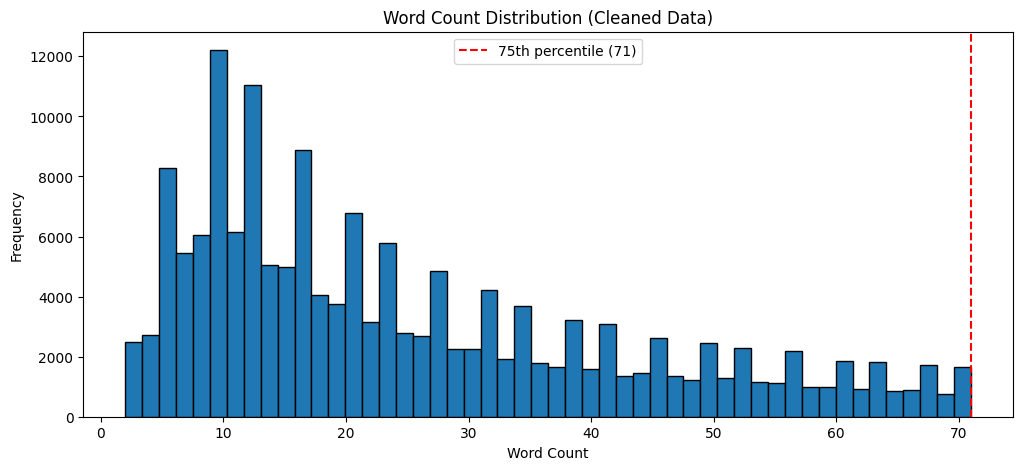

In [ ]:
# Based on project: use 75th percentile as threshold
percentile_75 = df_cleaned['word_count'].quantile(0.75)
print(f"75th percentile word count: {percentile_75:.0f}")

# Remove posts exceeding this threshold
df_cleaned = df_cleaned[df_cleaned['word_count'] <= percentile_75].copy()

print(f"After removing outliers (word_count > {percentile_75:.0f}): {len(df_cleaned)}")

# Visualize cleaned data
plt.figure(figsize=(12, 5))
plt.hist(df_cleaned['word_count'], bins=50, edgecolor='black')
plt.axvline(percentile_75, color='red', linestyle='--', label=f'75th percentile ({percentile_75:.0f})')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Word Count Distribution (Cleaned Data)')
plt.legend()
plt.show()

In [ ]:
print("=" * 80)
print("FINAL CLEANED DATASET SUMMARY")
print("=" * 80)
print(f"Total samples: {len(df_cleaned)}")
print(f"\nClass distribution:")
print(df_cleaned['class'].value_counts())
print(f"\nClass distribution (%):")
print((df_cleaned['class'].value_counts() / len(df_cleaned) * 100).round(2))
print(f"\nWord count statistics:")
print(df_cleaned['word_count'].describe())
print(f"\nMissing values:")
print(df_cleaned.isnull().sum())


# Save cleaned data
df_cleaned_final = df_cleaned[['text', 'class']].reset_index(drop=True)
df_cleaned_final.to_csv('suicide_detection_cleaned.csv', index=False)
print("\n✓ Cleaned data saved as 'suicide_detection_cleaned.csv'")
# Save directly to Google Drive
df_cleaned_final.to_csv('/content/drive/MyDrive/dataset/suicide_detection_cleaned.csv', index=False)
print("\n✓ Cleaned data saved to Google Drive")

FINAL CLEANED DATASET SUMMARY
Total samples: 163867

Class distribution:
class
non-suicide    102093
suicide         61774
Name: count, dtype: int64

Class distribution (%):
class
non-suicide    62.3
suicide        37.7
Name: count, dtype: float64

Word count statistics:
count    163867.000000
mean         25.294135
std          17.688680
min           2.000000
25%          11.000000
50%          20.000000
75%          36.000000
max          71.000000
Name: word_count, dtype: float64

Missing values:
Unnamed: 0     0
text           0
class          0
text_length    0
word_count     0
dtype: int64

✓ Cleaned data saved as 'suicide_detection_cleaned.csv'

✓ Cleaned data saved to Google Drive


In [ ]:
import pandas as pd

df_cleaned_final = pd.read_csv('/content/drive/MyDrive/dataset/suicide_detection_cleaned.csv')

# Optional: preview the data
df_cleaned_final.head()


,text,class
0,ex wife threatening suiciderecently left wife ...,suicide
1,weird dont get affected compliment coming some...,non-suicide
2,finally almost never hear bad year ever swear ...,non-suicide
3,need helpjust help im cry hard,suicide
4,end tonighti cant anymore quit,suicide


#Step 6: Exploratory Data Analysis (EDA) on Cleaned Data
6.1 Word Cloud Analysis

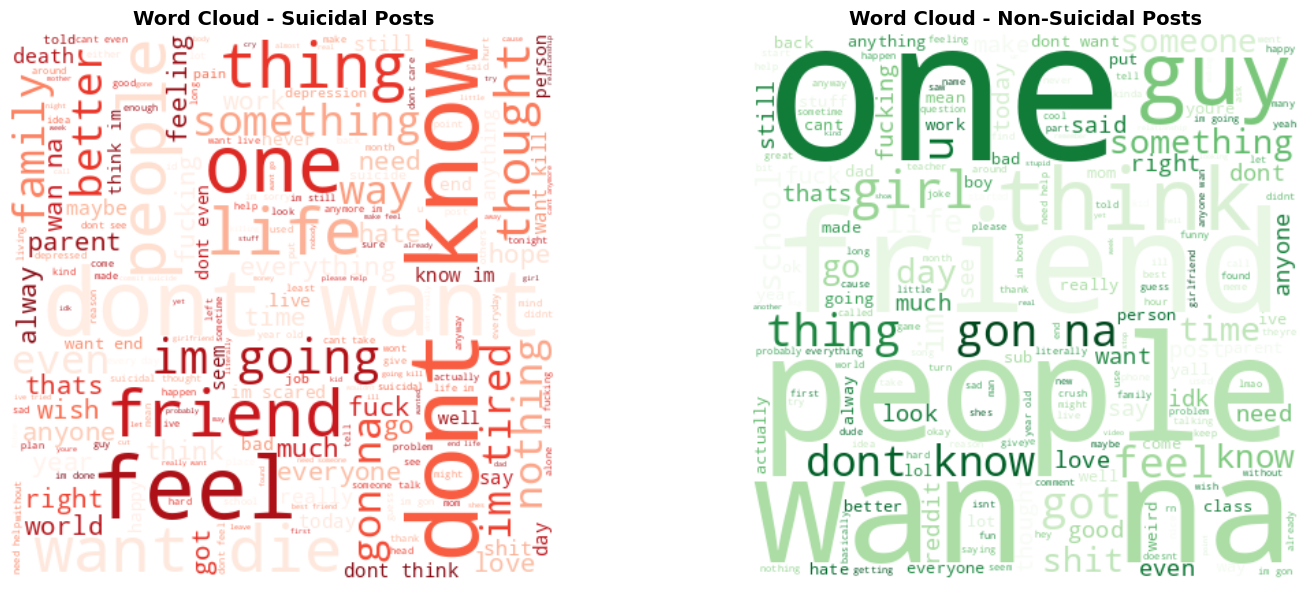

✓ Word clouds generated!


In [ ]:
from wordcloud import WordCloud

# Separate by class
suicidal_text = ' '.join(df_cleaned_final[df_cleaned_final['class'] == 'suicide']['text'])
non_suicidal_text = ' '.join(df_cleaned_final[df_cleaned_final['class'] == 'non-suicide']['text'])

# Create word clouds
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Suicidal word cloud
wc_suicidal = WordCloud(width=400, height=400, background_color='white', colormap='Reds').generate(suicidal_text)
axes[0].imshow(wc_suicidal, interpolation='bilinear')
axes[0].set_title('Word Cloud - Suicidal Posts', fontsize=14, fontweight='bold')
axes[0].axis('off')

# Non-suicidal word cloud
wc_non_suicidal = WordCloud(width=400, height=400, background_color='white', colormap='Greens').generate(non_suicidal_text)
axes[1].imshow(wc_non_suicidal, interpolation='bilinear')
axes[1].set_title('Word Cloud - Non-Suicidal Posts', fontsize=14, fontweight='bold')
axes[1].axis('off')

plt.tight_layout()
plt.show()

print("✓ Word clouds generated!")

6.2 Bigrams Analysis

In [ ]:
def get_bigrams(text):
    tokens = text.split()
    bigrams = list(zip(tokens, tokens[1:]))
    return bigrams

# Get bigrams for each class
suicidal_bigrams = []
non_suicidal_bigrams = []

for text in df_cleaned_final[df_cleaned_final['class'] == 'suicide']['text']:
    suicidal_bigrams.extend(get_bigrams(text))

for text in df_cleaned_final[df_cleaned_final['class'] == 'non-suicide']['text']:
    non_suicidal_bigrams.extend(get_bigrams(text))

# Count bigrams
suicidal_bigram_freq = Counter(suicidal_bigrams)
non_suicidal_bigram_freq = Counter(non_suicidal_bigrams)

print("Top 15 bigrams in SUICIDAL posts:")
for bigram, count in suicidal_bigram_freq.most_common(15):
    print(f"{' '.join(bigram)}: {count}")

print("\nTop 15 bigrams in NON-SUICIDAL posts:")
for bigram, count in non_suicidal_bigram_freq.most_common(15):
    print(f"{' '.join(bigram)}: {count}")

Top 15 bigrams in SUICIDAL posts:
dont know: 10272
feel like: 9864
dont want: 9442
im not: 5395
no one: 5110
want die: 4341
im going: 3729
im tired: 3181
gon na: 3147
wan na: 2867
get better: 2351
like im: 2261
dont think: 2112
know im: 2017
want kill: 2010

Top 15 bigrams in NON-SUICIDAL posts:
wan na: 6258
gon na: 4363
dont know: 4059
im not: 3660
feel like: 3375
dont want: 1814
im bored: 1674
im gon: 1552
anyone else: 1475
year old: 1460
im going: 1387
need help: 1300
no one: 1264
anyone wan: 1183
like im: 1121


6.3 Sentiment Analysis

Polarity Statistics:
count    163867.000000
mean          0.000794
std           0.274889
min          -1.000000
25%          -0.150000
50%           0.000000
75%           0.148602
max           1.000000
Name: polarity, dtype: float64

Polarity by class:
                count      mean       std  min      25%       50%       75%  \
class                                                                         
non-suicide  102093.0  0.025304  0.289282 -1.0 -0.12500  0.000000  0.189899   
suicide       61774.0 -0.039713  0.243952 -1.0 -0.17952 -0.016667  0.098850   

             max  
class             
non-suicide  1.0  
suicide      1.0  


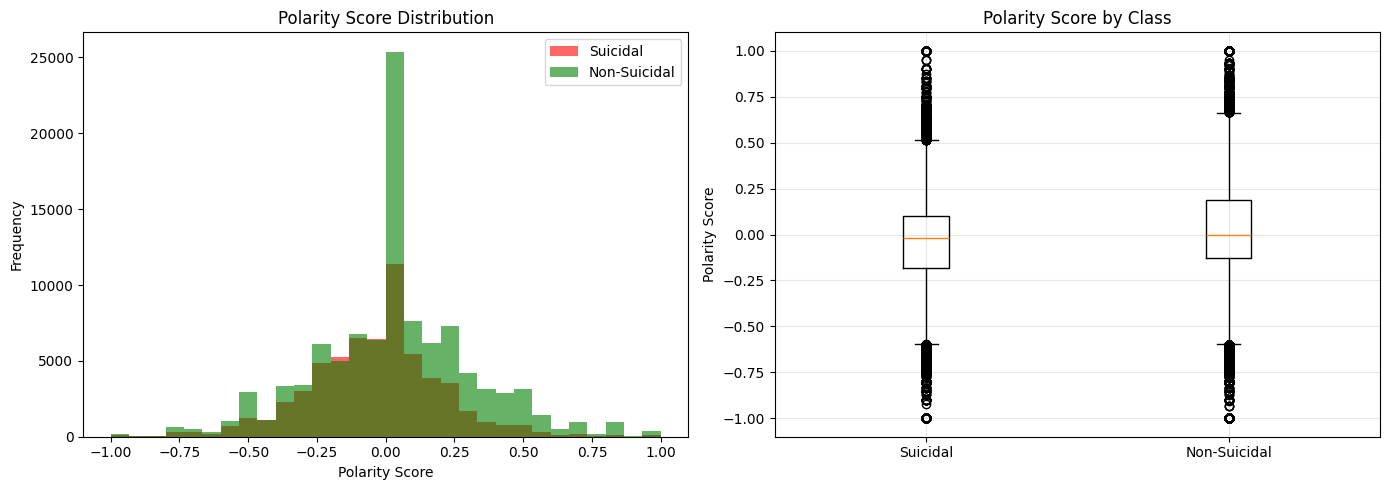

In [ ]:

from textblob import TextBlob

# Calculate polarity scores (-1 to 1)
df_cleaned_final['polarity'] = df_cleaned_final['text'].apply(
    lambda x: TextBlob(x).sentiment.polarity
)

print("Polarity Statistics:")
print(df_cleaned_final['polarity'].describe())

print("\nPolarity by class:")
print(df_cleaned_final.groupby('class')['polarity'].describe())

# Visualize polarity
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Distribution
axes[0].hist(df_cleaned_final[df_cleaned_final['class'] == 'suicide']['polarity'],
             bins=30, alpha=0.6, label='Suicidal', color='red')
axes[0].hist(df_cleaned_final[df_cleaned_final['class'] == 'non-suicide']['polarity'],
             bins=30, alpha=0.6, label='Non-Suicidal', color='green')
axes[0].set_xlabel('Polarity Score')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Polarity Score Distribution')
axes[0].legend()

# Box plot
data_to_plot = [
    df_cleaned_final[df_cleaned_final['class'] == 'suicide']['polarity'],
    df_cleaned_final[df_cleaned_final['class'] == 'non-suicide']['polarity']
]
axes[1].boxplot(data_to_plot, labels=['Suicidal', 'Non-Suicidal'])
axes[1].set_ylabel('Polarity Score')
axes[1].set_title('Polarity Score by Class')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Step 7: Prepare Data for Model Training
7.1 Encode Labels and Split Data

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Encode labels
label_encoder = LabelEncoder()
df_cleaned_final['label'] = label_encoder.fit_transform(df_cleaned_final['class'])

print("Label encoding:")
for i, class_name in enumerate(label_encoder.classes_):
    print(f"{class_name}: {i}")

# Extract texts and labels
X = df_cleaned_final['text'].values
y = df_cleaned_final['label'].values

print(f"\nTotal samples: {len(X)}")
print(f"Class distribution: {np.bincount(y)}")

# Split: 80% train, 10% validation, 10% test
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"\nTraining set: {len(X_train)} samples")
print(f"Validation set: {len(X_val)} samples")
print(f"Test set: {len(X_test)} samples")

print(f"\nTraining set class distribution: {np.bincount(y_train)}")
print(f"Validation set class distribution: {np.bincount(y_val)}")
print(f"Test set class distribution: {np.bincount(y_test)}")

Label encoding:
non-suicide: 0
suicide: 1

Total samples: 163867
Class distribution: [102093  61774]

Training set: 131093 samples
Validation set: 16387 samples
Test set: 16387 samples

Training set class distribution: [81674 49419]
Validation set class distribution: [10209  6178]
Test set class distribution: [10210  6177]


#Step 8: Create PyTorch Dataset and DataLoaders
8.1 Define Dataset Class

In [ ]:
from torch.utils.data import Dataset, DataLoader
import torch

class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = int(self.labels[idx])

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

print("✓ Dataset class defined!")

✓ Dataset class defined!


#Step 9: Load Pre-trained ELECTRA Model
9.1 Initialize Model

In [ ]:
from transformers import ElectraTokenizer

# Load ELECTRA tokenizer
tokenizer = ElectraTokenizer.from_pretrained('google/electra-base-discriminator')

# Create datasets
train_dataset = TextDataset(X_train, y_train, tokenizer, max_len=128)
val_dataset = TextDataset(X_val, y_val, tokenizer, max_len=128)
test_dataset = TextDataset(X_test, y_test, tokenizer, max_len=128)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"✓ DataLoaders created!")
print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

✓ DataLoaders created!
Training batches: 4097
Validation batches: 513
Test batches: 513


In [ ]:
from transformers import ElectraForSequenceClassification

# Load pre-trained ELECTRA model
model = ElectraForSequenceClassification.from_pretrained(
    'google/electra-base-discriminator',
    num_labels=2  # Binary classification
)

# Move to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(f"✓ Model loaded and moved to {device}")

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ Model loaded and moved to cuda


In [ ]:
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup

# Hyperparameters
learning_rate = 2e-5
epochs = 3
warmup_ratio = 0.1

# Optimizer
optimizer = AdamW(model.parameters(), lr=learning_rate)

# Calculate total steps
total_steps = len(train_loader) * epochs
warmup_steps = int(total_steps * warmup_ratio)

# Learning rate scheduler
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)

print(f"✓ Optimizer and scheduler configured!")
print(f"Total training steps: {total_steps}")
print(f"Warmup steps: {warmup_steps}")

✓ Optimizer and scheduler configured!
Total training steps: 12291
Warmup steps: 1229


In [ ]:
from tqdm import tqdm

def train_epoch(model, data_loader, optimizer, scheduler, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    progress_bar = tqdm(data_loader, desc="Training")

    for batch in progress_bar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        scheduler.step()

        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        progress_bar.set_postfix({
            'loss': loss.item(),
            'acc': correct / total
        })

    return total_loss / len(data_loader), correct / total

print("✓ Training function defined!")

✓ Training function defined!


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate(model, data_loader, device):
    model.eval()
    total_loss = 0
    predictions = []
    true_labels = []

    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            loss = outputs.loss
            total_loss += loss.item()

            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)

            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions, average='weighted', zero_division=0)
    recall = recall_score(true_labels, predictions, average='weighted', zero_division=0)
    f1 = f1_score(true_labels, predictions, average='weighted', zero_division=0)

    return {
        'loss': total_loss / len(data_loader),
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'predictions': predictions,
        'true_labels': true_labels
    }

print("✓ Evaluation function defined!")

✓ Evaluation function defined!


#Step 12: Train the ELECTRA Model
12.1 Main Training Loop

In [ ]:
import gc

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to GPU
model.to(device)

# Store metrics
best_f1 = 0
best_model_path = 'best_electra_model.pth'


best_val_loss = float('inf')
patience = 2  # Stop if validation loss doesn't improve for 2 epochs
patience_counter = 0


train_history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'val_f1': [],
    'val_precision': [],
    'val_recall': []
}

print("=" * 80)
print("STARTING TRAINING WITH EARLY STOPPING")
print("=" * 80)
print(f"Early Stopping Patience: {patience} epochs\n")

for epoch in range(epochs):
    print(f"\n{'='*80}")
    print(f"Epoch {epoch + 1}/{epochs}")
    print(f"{'='*80}")

    # Train
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, scheduler, device)
    train_history['train_loss'].append(train_loss)
    train_history['train_acc'].append(train_acc)

    print(f"\nTraining - Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}")

    # Validate
    val_results = evaluate(model, val_loader, device)
    train_history['val_loss'].append(val_results['loss'])
    train_history['val_acc'].append(val_results['accuracy'])
    train_history['val_f1'].append(val_results['f1'])
    train_history['val_precision'].append(val_results['precision'])
    train_history['val_recall'].append(val_results['recall'])

    print(f"Validation Results:")
    print(f"  Loss: {val_results['loss']:.4f}")
    print(f"  Accuracy: {val_results['accuracy']:.4f}")
    print(f"  Precision: {val_results['precision']:.4f}")
    print(f"  Recall: {val_results['recall']:.4f}")
    print(f"  F1 Score: {val_results['f1']:.4f}")

    # Save best model
    if val_results['f1'] > best_f1:
        best_f1 = val_results['f1']
        torch.save(model.state_dict(), best_model_path)
        print(f"\n✓ Best model saved! (F1: {best_f1:.4f})")
# FOR EARLY STOPPING (NEW)
    if val_results['loss'] < best_val_loss:
        best_val_loss = val_results['loss']
        patience_counter = 0
        print(f"✓ Validation loss improved: {best_val_loss:.4f}")
    else:
        patience_counter += 1
        print(f"✗ Validation loss did not improve. Patience: {patience_counter}/{patience}")

        if patience_counter >= patience:
            print(f"\n" + "=" * 80)
            print(f"EARLY STOPPING TRIGGERED!")
            print(f"Validation loss has not improved for {patience} consecutive epochs")
            print(f"Best validation loss: {best_val_loss:.4f}")
            print(f"=" * 80)
            break

    # Clear cache
    gc.collect()
    torch.cuda.empty_cache()

print("\n" + "="*80)
print("TRAINING COMPLETE!")
print("="*80)
print(f"\nTraining Summary:")
print(f"  Total epochs trained: {len(train_history['train_loss'])}")
print(f"  Best F1 Score: {best_f1:.4f}")
print(f"  Best Validation Loss: {best_val_loss:.4f}")

STARTING TRAINING WITH EARLY STOPPING
Early Stopping Patience: 2 epochs


Epoch 1/3


Training: 100%|██████████| 4097/4097 [44:36<00:00,  1.53it/s, loss=0.313, acc=0.954]



Training - Loss: 0.1286, Accuracy: 0.9536


Evaluating: 100%|██████████| 513/513 [01:57<00:00,  4.35it/s]


Validation Results:
  Loss: 0.0659
  Accuracy: 0.9799
  Precision: 0.9799
  Recall: 0.9799
  F1 Score: 0.9799

✓ Best model saved! (F1: 0.9799)
✓ Validation loss improved: 0.0659

Epoch 2/3


Training: 100%|██████████| 4097/4097 [44:36<00:00,  1.53it/s, loss=0.000791, acc=0.982]



Training - Loss: 0.0549, Accuracy: 0.9825


Evaluating: 100%|██████████| 513/513 [01:57<00:00,  4.35it/s]


Validation Results:
  Loss: 0.0569
  Accuracy: 0.9827
  Precision: 0.9827
  Recall: 0.9827
  F1 Score: 0.9827

✓ Best model saved! (F1: 0.9827)
✓ Validation loss improved: 0.0569

Epoch 3/3


Training: 100%|██████████| 4097/4097 [44:36<00:00,  1.53it/s, loss=0.00192, acc=0.991]



Training - Loss: 0.0309, Accuracy: 0.9909


Evaluating: 100%|██████████| 513/513 [01:57<00:00,  4.38it/s]


Validation Results:
  Loss: 0.0712
  Accuracy: 0.9821
  Precision: 0.9820
  Recall: 0.9821
  F1 Score: 0.9820
✗ Validation loss did not improve. Patience: 1/2

TRAINING COMPLETE!

Training Summary:
  Total epochs trained: 3
  Best F1 Score: 0.9827
  Best Validation Loss: 0.0569


In [ ]:
# Load best model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to GPU
model.to(device)
model.load_state_dict(torch.load(best_model_path))

# Evaluate on test set
test_results = evaluate(model, test_loader, device)

print("\n" + "="*80)
print("TEST SET RESULTS")
print("="*80)
print(f"Loss: {test_results['loss']:.4f}")
print(f"Accuracy: {test_results['accuracy']:.4f}")
print(f"Precision: {test_results['precision']:.4f}")
print(f"Recall: {test_results['recall']:.4f}")
print(f"F1 Score: {test_results['f1']:.4f}")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Define save path inside your Google Drive
save_path = '/content/drive/MyDrive/electra_suicidal_text_detector'

# Save model and tokenizer to Drive folder
model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)

print("✓ Model and tokenizer saved to Google Drive!")
print(f"Files saved in '{save_path}' directory")

# List saved files
import os
print("\nSaved files:")
for file in os.listdir(save_path):
    print(f"  - {file}")


✓ Model and tokenizer saved to Google Drive!
Files saved in '/content/drive/MyDrive/electra_suicidal_text_detector' directory

Saved files:
  - config.json
  - model.safetensors
  - tokenizer_config.json
  - special_tokens_map.json
  - vocab.txt



DETAILED CLASSIFICATION REPORT
              precision    recall  f1-score   support

    Suicidal       0.97      0.98      0.98      1634
Non-Suicidal       0.96      0.96      0.96       980

    accuracy                           0.97      2614
   macro avg       0.97      0.97      0.97      2614
weighted avg       0.97      0.97      0.97      2614


Confusion Matrix:
[[1598   36]
 [  43  937]]


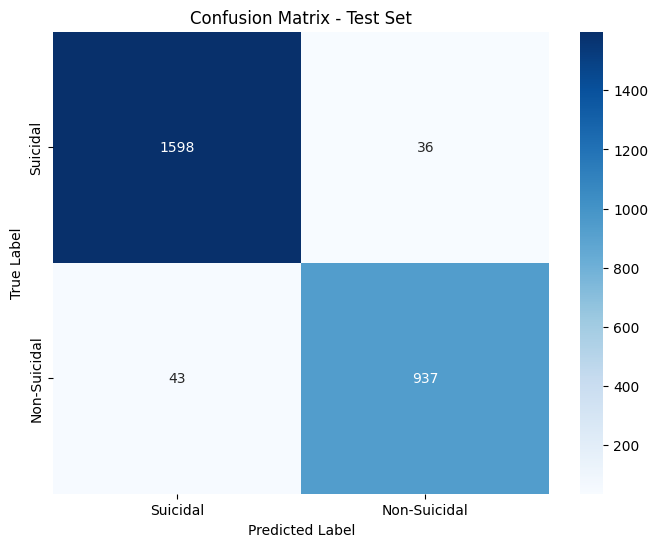

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

print("\n" + "="*80)
print("DETAILED CLASSIFICATION REPORT")
print("="*80)
print(classification_report(
    test_results['true_labels'],
    test_results['predictions'],
    target_names=['Suicidal', 'Non-Suicidal']
))

# Confusion matrix
cm = confusion_matrix(test_results['true_labels'], test_results['predictions'])
print("\nConfusion Matrix:")
print(cm)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Suicidal', 'Non-Suicidal'],
            yticklabels=['Suicidal', 'Non-Suicidal'])
plt.title('Confusion Matrix - Test Set')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

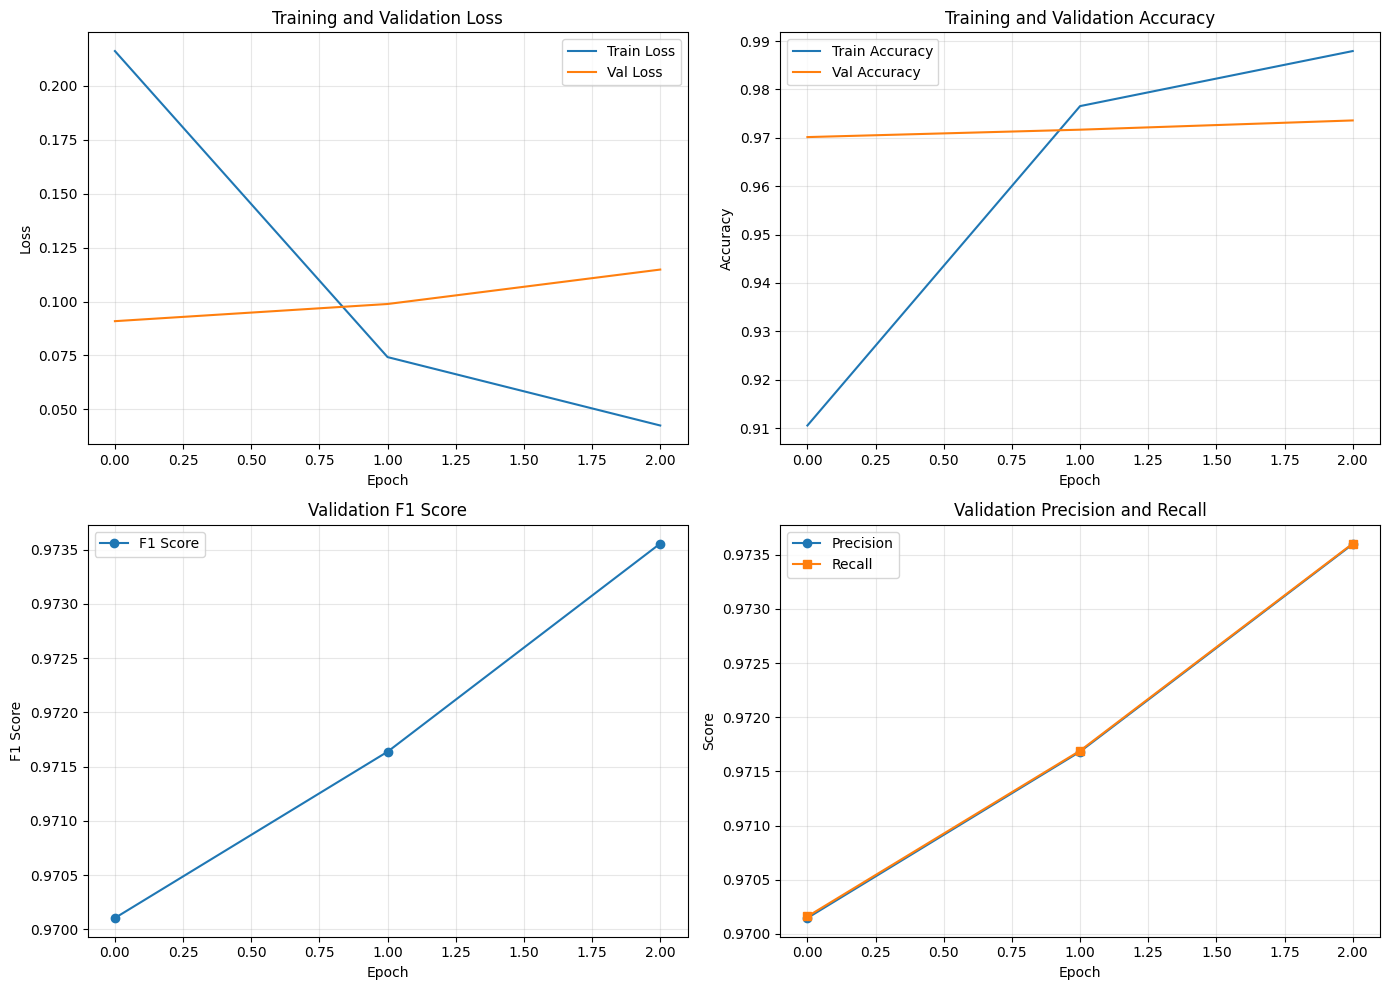

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Loss
axes[0, 0].plot(train_history['train_loss'], label='Train Loss')
axes[0, 0].plot(train_history['val_loss'], label='Val Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training and Validation Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Accuracy
axes[0, 1].plot(train_history['train_acc'], label='Train Accuracy')
axes[0, 1].plot(train_history['val_acc'], label='Val Accuracy')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].set_title('Training and Validation Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# F1 Score
axes[1, 0].plot(train_history['val_f1'], marker='o', label='F1 Score')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('F1 Score')
axes[1, 0].set_title('Validation F1 Score')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Precision and Recall
axes[1, 1].plot(train_history['val_precision'], marker='o', label='Precision')
axes[1, 1].plot(train_history['val_recall'], marker='s', label='Recall')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Score')
axes[1, 1].set_title('Validation Precision and Recall')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Save model and tokenizer
model.save_pretrained('electra_suicidal_text_detector')
tokenizer.save_pretrained('electra_suicidal_text_detector')

print("✓ Model and tokenizer saved!")
print("Files saved in 'electra_suicidal_text_detector' directory")

# List saved files
import os
print("\nSaved files:")
for file in os.listdir('electra_suicidal_text_detector'):
    print(f"  - {file}")

#TEST

In [ ]:
# Evaluate on test set
from tqdm.notebook import tqdm
test_results = evaluate(model, test_loader, device)

print("\n" + "="*80)
print("TEST SET RESULTS")
print("="*80)
print(f"Loss: {test_results['loss']:.4f}")
print(f"Accuracy: {test_results['accuracy']:.4f}")
print(f"Precision: {test_results['precision']:.4f}")
print(f"Recall: {test_results['recall']:.4f}")
print(f"F1 Score: {test_results['f1']:.4f}")

Evaluating:   0%|          | 0/513 [00:00<?, ?it/s]


TEST SET RESULTS
Loss: 0.0606
Accuracy: 0.9833
Precision: 0.9833
Recall: 0.9833
F1 Score: 0.9833
